In [1]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [2]:
!kaggle datasets download -d forderation/breakhis-400x

 98% 785M/803M [00:10<00:00, 109MB/s] 
100% 803M/803M [00:10<00:00, 83.3MB/s]


In [3]:
import tensorflow as tf
from zipfile import ZipFile
import os,glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from zipfile import ZipFile


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator



<ipython-input-3-05058baccfba>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook as tqdm


In [4]:
filename="/content/breakhis-400x.zip"

In [5]:
with ZipFile(filename,'r') as f:
  f.extractall()
  print("done")

done


['SOB_B_F-14-23060CD-400-001.png', 'SOB_B_F-14-23060AB-400-001.png', 'SOB_B_TA-14-16184CD-400-002.png', 'SOB_B_F-14-23222AB-400-004.png', 'SOB_B_A-14-22549G-400-011.png']
['SOB_M_DC-14-20629-400-007.png', 'SOB_M_MC-14-10147-400-001.png', 'SOB_M_DC-14-16601-400-001.png', 'SOB_M_LC-14-15570C-400-021.png', 'SOB_M_DC-14-2773-400-024.png']


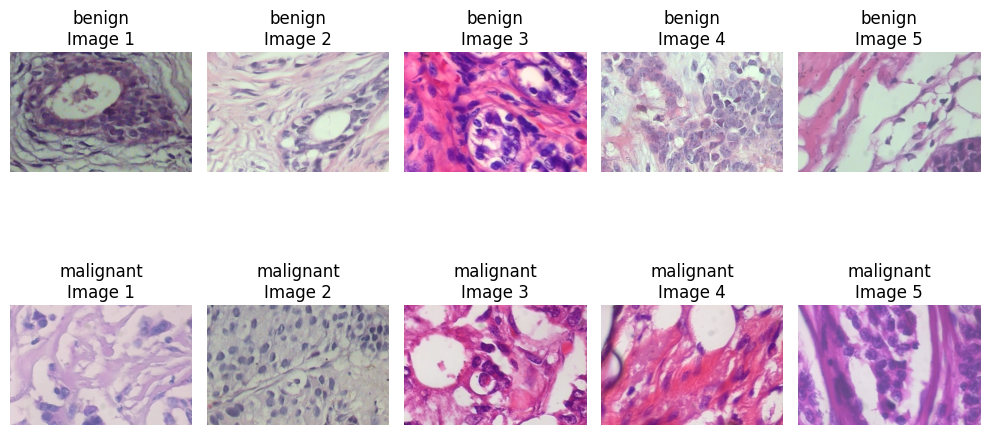

In [15]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# Define your dataset folder and class subfolders
dataset_folder = '/content/BreaKHis 400X/train'
class_folders = ['benign', 'malignant']  # Names of your class subfolders

# Visualize a few images from each class
num_images_per_class = 5

plt.figure(figsize=(10, 6))

for class_folder in class_folders:
    class_folder_path = os.path.join(dataset_folder, class_folder)
    images = os.listdir(class_folder_path)[:num_images_per_class]
    print(images)

    for i, image_name in enumerate(images, start=1):
        image_path = os.path.join(class_folder_path, image_name)
        image = Image.open(image_path)

        plt.subplot(len(class_folders), num_images_per_class, (class_folders.index(class_folder) * num_images_per_class) + i)
        plt.imshow(image)
        plt.title(f'{class_folder}\nImage {i}')
        plt.axis('off')

plt.tight_layout()
plt.show()


In [16]:
# Set the paths for train and test data folders
train_data_dir = '/content/BreaKHis 400X/train'
test_data_dir = '/content/BreaKHis 400X/test'

In [17]:
# Image dimensions and batch size
img_height, img_width = 224, 224
batch_size = 32

In [18]:
# Create ImageDataGenerator for data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(
    rescale=1.0/255
)


In [19]:
# Create generators for train and test data
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 1148 images belonging to 2 classes.
Found 545 images belonging to 2 classes.


In [20]:
# Load the VGG16 model without top layers (include_top=False)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))


58889256/58889256 [==============================] - 0s 0us/step


In [21]:
# Add custom top layers for classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [22]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [26]:
## Create checkpoints to save best weight when accuracy is high and loss is low
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
# Checkpoint to save best model per epoch

model_filepath = "/content/BreaKHis 400X/model-{epoch:02d}-{val_accuracy:.4f}.hdf5"

checkpoint = ModelCheckpoint(
    filepath=model_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)



early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=5,  # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)



In [27]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=100,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size,
    callbacks=[checkpoint,early_stopping]
)


Epoch 1/100
35/35 [==============================] - ETA: 0s - loss: 0.6314 - accuracy: 0.6810
Epoch 1: val_accuracy improved from -inf to 0.67647, saving model to /content/BreaKHis 400X/model-01-0.6765.hdf5
35/35 [==============================] - 40s 1s/step - loss: 0.6314 - accuracy: 0.6810 - val_loss: 0.6310 - val_accuracy: 0.6765
Epoch 2/100
35/35 [==============================] - ETA: 0s - loss: 0.6299 - accuracy: 0.6783
Epoch 2: val_accuracy did not improve from 0.67647
35/35 [==============================] - 40s 1s/step - loss: 0.6299 - accuracy: 0.6783 - val_loss: 0.6271 - val_accuracy: 0.6765
Epoch 3/100
35/35 [==============================] - ETA: 0s - loss: 0.6244 - accuracy: 0.6810
Epoch 3: val_accuracy improved from 0.67647 to 0.67831, saving model to /content/BreaKHis 400X/model-03-0.6783.hdf5
35/35 [==============================] - 37s 1s/step - loss: 0.6244 - accuracy: 0.6810 - val_loss: 0.6188 - val_accuracy: 0.6783
Epoch 4/100
35/35 [=============================

1/1 [==============================] - 0s 139ms/step


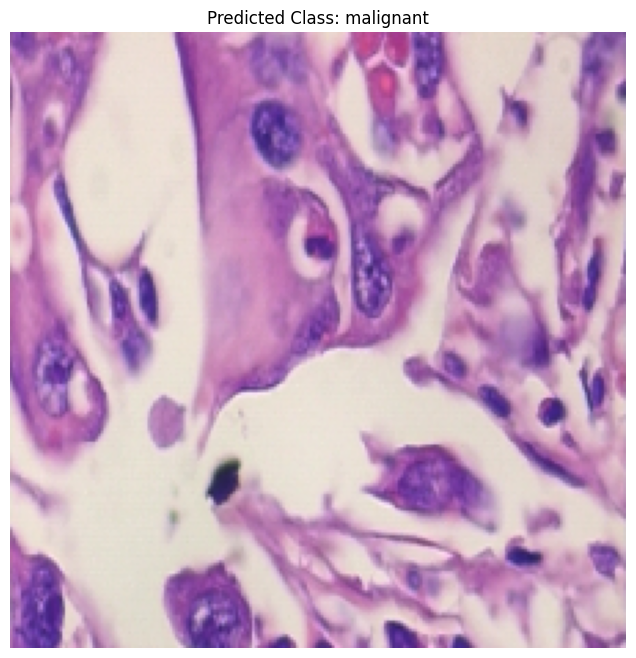

In [33]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img


# Load and preprocess the image for prediction
img_path = '/content/BreaKHis 400X/train/malignant/SOB_M_DC-14-10926-400-002.png'  # Replace with the path of your image
# img= Image.open(img_path,target_size=(224, 224))
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

class_names=['benign','malignant']
# Load the trained model
model = load_model('/content/BreaKHis 400X/model-22-0.8621.hdf5')
# Make predictions
predictions = model.predict(img_array)

# Get the predicted class index
predicted_class_index = np.argmax(predictions[0])

# Get the predicted class label
predicted_class_label = class_names[predicted_class_index]

# Plot the image with its label
plt.figure(figsize=(8, 8))
plt.imshow(img)
plt.title(f'Predicted Class: {predicted_class_label}')
plt.axis('off')
plt.show()
